# Table of Contents
 <p><div class="lev1 toc-item"><a href="#Import-useful-libraries" data-toc-modified-id="Import-useful-libraries-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Import useful libraries</a></div><div class="lev1 toc-item"><a href="#Connect-to-Database" data-toc-modified-id="Connect-to-Database-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Connect to Database</a></div><div class="lev1 toc-item"><a href="#Autofill-Table-Names" data-toc-modified-id="Autofill-Table-Names-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Autofill Table Names</a></div><div class="lev1 toc-item"><a href="#Magic-Functions-Useful-for-Interacting-with-the-Cluster" data-toc-modified-id="Magic-Functions-Useful-for-Interacting-with-the-Cluster-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Magic Functions Useful for Interacting with the Cluster</a></div><div class="lev1 toc-item"><a href="#Create-Fake-Data" data-toc-modified-id="Create-Fake-Data-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Create Fake Data</a></div><div class="lev2 toc-item"><a href="#Create-Fake-ROC-Data" data-toc-modified-id="Create-Fake-ROC-Data-51"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>Create Fake ROC Data</a></div><div class="lev1 toc-item"><a href="#Pulling-Data" data-toc-modified-id="Pulling-Data-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Pulling Data</a></div><div class="lev2 toc-item"><a href="#Generate-and-Plot-the-Histogram-Locally" data-toc-modified-id="Generate-and-Plot-the-Histogram-Locally-61"><span class="toc-item-num">6.1&nbsp;&nbsp;</span>Generate and Plot the Histogram Locally</a></div><div class="lev2 toc-item"><a href="#Generate-the-Histogram-in-Database-and-Plot-Locally" data-toc-modified-id="Generate-the-Histogram-in-Database-and-Plot-Locally-62"><span class="toc-item-num">6.2&nbsp;&nbsp;</span>Generate the Histogram in Database and Plot Locally</a></div><div class="lev2 toc-item"><a href="#Generate-the-Scatter-Plot-in-Database-and-Plot-Locally" data-toc-modified-id="Generate-the-Scatter-Plot-in-Database-and-Plot-Locally-63"><span class="toc-item-num">6.3&nbsp;&nbsp;</span>Generate the Scatter Plot in Database and Plot Locally</a></div><div class="lev2 toc-item"><a href="#Generate-the-ROC-Curve" data-toc-modified-id="Generate-the-ROC-Curve-64"><span class="toc-item-num">6.4&nbsp;&nbsp;</span>Generate the ROC Curve</a></div><div class="lev3 toc-item"><a href="#Local-Version" data-toc-modified-id="Local-Version-641"><span class="toc-item-num">6.4.1&nbsp;&nbsp;</span>Local Version</a></div><div class="lev3 toc-item"><a href="#In-Database-version" data-toc-modified-id="In-Database-version-642"><span class="toc-item-num">6.4.2&nbsp;&nbsp;</span>In-Database version</a></div>

<a href='http://pivotal.io/data-science'><img src='https://raw.githubusercontent.com/crawles/Logos/master/Pivotal_TealOnWhite.png' width='200px' align='right'></a>

# Import useful libraries

In [1]:
from datetime import datetime
from dateutil.relativedelta import relativedelta
import getopt
import os
import sys
from textwrap import dedent
import urllib

from IPython.core.display import display, HTML
from IPython.core.magic import register_cell_magic, register_line_cell_magic, register_line_magic
# If we want to move the graph
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pandas.io.sql as psql
import psycopg2
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, roc_curve

# Credentials file to connect to database
import credentials
from mpp_plotting_functions import *
# from sql_functions import *

In [2]:
# Changes logo to a Pivotal logo
jPrefs = urllib.urlopen("https://raw.githubusercontent.com/crawles/Logos/master/jupyterPrefs.js").read()
HTML('<script>{}</script>'.format(jPrefs))

In [3]:
# Set default cell width
display(HTML('<style>.container {width:80% !important;}</style>'))

# Set default matplotlib settings
plt.rcParams['figure.figsize'] = (10, 7)
plt.rcParams['lines.linewidth'] = 3
plt.rcParams['figure.titlesize'] = 26
plt.rcParams['axes.labelsize'] = 18
plt.rcParams['axes.titlesize'] = 22
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14
plt.rcParams['legend.fontsize'] = 16

# Set seaborn colours
blue, green, red, purple, yellow, cyan = sns.color_palette()

# Connect to Database

In [4]:
conn = psycopg2.connect(**credentials.login_info_dict)
conn.autocommit = True

# Set the schema name
schema_name = 'template'
psql.execute('SET search_path TO {}'.format(schema_name), conn)

<cursor object at 0x11a0ca350; closed: 0>

# Autofill Table Names
One downside of interacting with a remote database in Python is that table names will not be imported in. When this is run, it will import all of the schema names as classes and their respective table names as variables. That way, when we type a schema name, we can use tab completion to list out all of its columns.

In [5]:
class Schema:
    def __init__(self, tables):
        for t in tables:
            exec('self.{t} = "{t}"'.format(t=t))

def refresh_tables(conn):
    """Refreshes the auto-fill tables."""
    sql = '''
    SELECT table_schema, array_agg(table_name::TEXT) AS tables
      FROM information_schema.tables
     GROUP BY table_schema;
    '''
    info_df = psql.read_sql(sql, conn)

    for row in info_df.iterrows():
        command = '''
        global {s}
        {s} = Schema({tables})
        '''.format(s=row[1][0], tables=row[1][1])
        exec(dedent(command))

# Magic Functions Useful for Interacting with the Cluster
These functions allow us to type write and run raw SQL a cell with the magic function at the top.

In [6]:
@register_cell_magic
def readsql(line, cell):
    """
    Extract the code in the specific cell (should be valid SQL), 
    and execute it using the connection object to the backend 
    database. The resulting pandas DataFrame is rendered inline 
    below the cell using IPython.display. You'd use this for SELECT.
    
    Returns a DataFrame with the name specified in the magic
    function. If this is not specified, then the DataFrame
    is called _df. This also takes in an option "-h", followed 
    by a number. This will show only the specified number of rows
    in the DataFrame.
    """
    
    # Use the global connection object defined above.
    global conn
    optlist, args = getopt.getopt(line.split(), 'ih:')
    optdict = dict(optlist) 
    # If '-h' tag is specified, set the number of rows to display
    if '-h' in optdict:
        head_num = int(optdict['-h'])
    
    # Do string formatting. If a PL/Python function
    # is being created, then it should not try and
    # format whatever is inside the function.
    split_cell = cell.split('$')
    if '-i' not in optdict:
        if len(split_cell) > 1:
            split_cell[0] = split_cell[0].format(**globals())
            split_cell[-1] = split_cell[-1].format(**globals())
            cell = '$'.join(split_cell)
        elif len(split_cell) == 1:
            cell = cell.format(**globals()) 
    
    # If there is more than one table name specified,
    # throw an exception.
    if len(args) > 1:
        raise Exception('More than one table name specified.')

    elif len(args) == 1:
        # If a table name is specified, store it as that
        table_name = args[0]
        globals()[table_name] = psql.read_sql(cell, conn)
        if '-h' in optdict:
            # If head_num is not 0, then display rows
            if head_num != 0:
                display(globals()[table_name].head(int(optdict['-h'])))
        else:
            display(globals()[table_name])

    else:
        # Otherwise, call it _df
        global _df
        _df = psql.read_sql(cell, conn)
        if '-h' in optdict:
            # If head_num is not 0, then display rows
            if head_num != 0:
                display(_df.head(head_num))
        else:
            display(_df)
            
    refresh_tables(conn)

@register_cell_magic
def execsql(line, cell):
    """
    Extract the code in the specific cell (should be valid SQL),
    and execute it using the connection object to the backend 
    database. You'd use this for CREATE/UPDATE/DELETE.
    """
    
    # Use the global connection object defined above.
    global conn
    optlist, args = getopt.getopt(line.split(), 'ih:')
    optdict = dict(optlist)
    
    # Do string formatting. If a PL/Python function
    # is being created, then it should not try and
    # format whatever is inside the function.
    split_cell = cell.split('$')
    if '-i' not in optdict:
        if len(split_cell) > 1:
            split_cell[0] = split_cell[0].format(**globals())
            split_cell[-1] = split_cell[-1].format(**globals())
            cell = '$'.join(split_cell)
        elif len(split_cell) == 1:
            cell = cell.format(**globals())
    psql.execute(cell, conn)
    refresh_tables(conn)

@register_cell_magic
def printsql(line, cell):
    """
    Show the SQL query that will be run.
    """
    
    optlist, args = getopt.getopt(line.split(), 'ih:')
    optdict = dict(optlist)
    
    # Do string formatting. If a PL/Python function
    # is being created, then it should not try and
    # format whatever is inside the function.
    split_cell = cell.split('$')
    if '-i' not in optdict:
        if len(split_cell) > 1:
            split_cell[0] = split_cell[0].format(**globals())
            split_cell[-1] = split_cell[-1].format(**globals())
            cell = '$'.join(split_cell)
        elif len(split_cell) == 1:
            cell = cell.format(**globals())
    print cell

# We delete these to avoid name conflicts for automagic to work
del execsql, readsql, printsql

# Create Fake Data

In [7]:
%%execsql
-- Function to create normally distributed data.
DROP FUNCTION IF EXISTS generate_normal_data(loc NUMERIC, 
                                             scale NUMERIC,
                                             size INT);
CREATE OR REPLACE FUNCTION generate_normal_data(loc NUMERIC,
                                                scale NUMERIC,
                                                size INT
                                               )
RETURNS SETOF NUMERIC AS
$$
    import numpy as np

    return np.random.normal(loc, scale, size)
$$
LANGUAGE plpythonu IMMUTABLE;

In [8]:
%%execsql
DROP TABLE IF EXISTS table_name;
CREATE TABLE table_name
   AS SELECT random()^2 * 50 AS column_name,
             generate_normal_data(0.0, 1.0, 1) AS column_name_x,
             generate_normal_data(0.0, 1.0, 1) AS column_name_y
        FROM generate_series(1, 10000);

In [9]:
%%readsql
SELECT *
  FROM table_name
 LIMIT 10;

,column_name,column_name_x,column_name_y
0,4.442591,-0.115331,-0.004448
1,28.528292,2.488169,-0.738694
2,27.661891,-0.414249,-1.676483
3,12.048221,-1.183919,0.644504
4,33.438114,-0.541811,-0.855599
5,0.337296,1.125490,1.596848
6,6.713415,-0.379125,-0.043391
7,0.001641,-0.411614,0.734781
8,4.553244,-1.102485,0.431742
9,4.733654,-2.208907,-0.386118


## Create Fake ROC Data

In [10]:
abalone_df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/abalone/abalone.data', header=None)
abalone_df.columns = ['sex', 'length', 'diameter', 'height', 'whole_wt', 'shucked_wt', 'viscera_wt', 'shell_wt', 'rings']
abalone_df['y'] = abalone_df['length'].map(lambda x: 1 if x > 0.4 else 0)

In [11]:
np.random.seed(1)
clf = RandomForestClassifier(n_estimators=5)

X = ['diameter', 'height', 'whole_wt', 'shucked_wt', 'viscera_wt', 'shell_wt', 'rings']
X = ['rings']
clf.fit(abalone_df[X], abalone_df['y'])

abalone_df['score'] = clf.predict_proba(abalone_df[X])[:, 1]

Now, we will upload this data to Postgres.

In [12]:
y_true_str = str(abalone_df['y'].tolist())[1:-1]
y_score_str = str(abalone_df['score'].tolist())[1:-1]

In [13]:
%%execsql
DROP TABLE IF EXISTS model_scores;
CREATE TABLE model_scores
   AS SELECT UNNEST(ARRAY[{y_true_str}]) AS y_true,
             UNNEST(ARRAY[{y_score_str}]) AS y_score;
--DISTRIBUTED RANDOMLY

# Pulling Data

## Generate and Plot the Histogram Locally

In [14]:
%%readsql -h 10 df_real
SELECT *
  FROM table_name
 WHERE column_name IS NOT NULL;

,column_name,column_name_x,column_name_y
0,4.442591,-0.115331,-0.004448
1,28.528292,2.488169,-0.738694
2,27.661891,-0.414249,-1.676483
3,12.048221,-1.183919,0.644504
4,33.438114,-0.541811,-0.855599
5,0.337296,1.125490,1.596848
6,6.713415,-0.379125,-0.043391
7,0.001641,-0.411614,0.734781
8,4.553244,-1.102485,0.431742
9,4.733654,-2.208907,-0.386118


## Generate the Histogram in Database and Plot Locally

In [15]:
%%execsql
DROP TABLE IF EXISTS histogram_values;
CREATE TABLE histogram_values
     AS WITH min_max_table AS
             (SELECT MIN(column_name) AS min_val,
                     MAX(column_name) AS max_val
                FROM table_name
             ),
             binned_table AS
             (SELECT CASE WHEN column_name < max_val
                               THEN FLOOR((column_name - min_val)::NUMERIC
                                          /(max_val - min_val)
                                          * 25
                                         )
                                    /25 * (max_val - min_val) 
                                    + min_val
                          WHEN column_name = max_val
                               THEN (25 - 1)::NUMERIC/25 * (max_val - min_val) 
                                    + min_val
                          ELSE NULL
                           END AS bin_loc
                FROM table_name
                     CROSS JOIN min_max_table
               WHERE column_name IS NOT NULL
             )
      SELECT bin_loc, COUNT(*) AS bin_height
        FROM binned_table
       GROUP BY bin_loc
       ORDER BY bin_loc
-- DISTRIBUTED BY (bin_loc);

In [16]:
sql = '''
SELECT *
  FROM histogram_values
 ORDER BY bin_loc;
'''
py_hist_df = psql.read_sql(sql, conn)

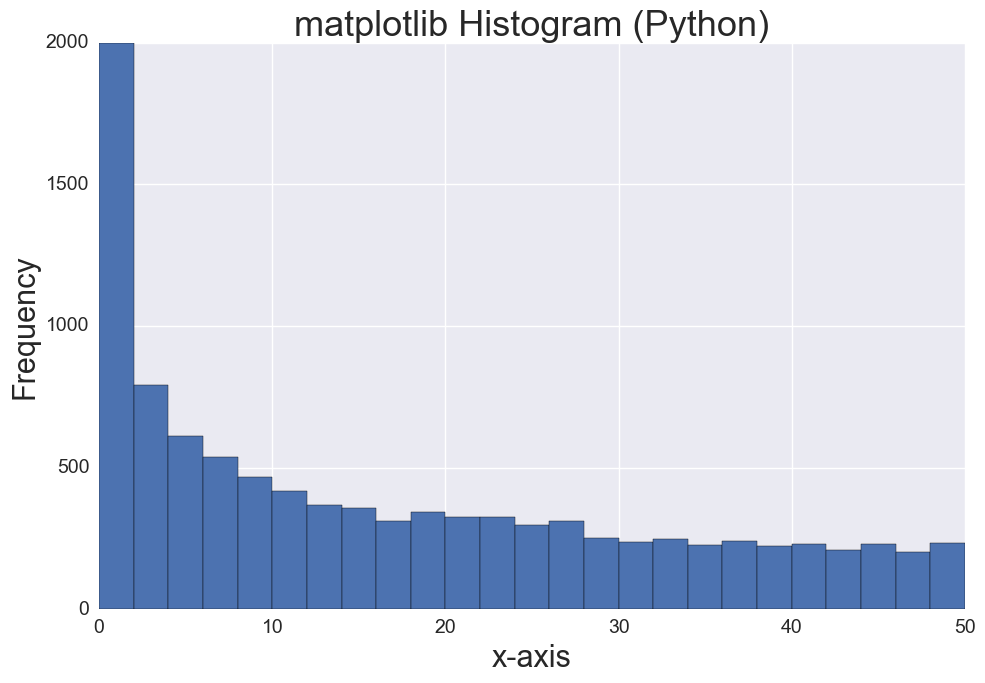

In [17]:
bin_width = py_hist_df.bin_loc.diff().mean()

plt.figure(figsize=(10, 7))
plt.bar(py_hist_df.bin_loc, py_hist_df.bin_height,
        width=bin_width, edgecolor='black')
plt.title('matplotlib Histogram (Python)', size=26)
plt.xlabel('x-axis', size=22)
plt.ylabel('Frequency', size=22)
plt.xticks(size=14)
plt.yticks(size=14)
plt.tight_layout()

plt.savefig('python_histogram.png')

## Generate the Scatter Plot in Database and Plot Locally

In [18]:
%%execsql
DROP TABLE IF EXISTS scatter_plot_values;
CREATE TABLE scatter_plot_values
     AS WITH min_max_table AS
             (SELECT MIN(column_name_x) AS min_val_x,
                     MAX(column_name_x) AS max_val_x,
                     MIN(column_name_y) AS min_val_y,
                     MAX(column_name_y) AS max_val_y
                FROM table_name
             ),
             binned_table AS
             (SELECT CASE WHEN column_name_x < max_val_x
                               THEN FLOOR((column_name_x - min_val_x)::NUMERIC
                                          /(max_val_x - min_val_x)
                                          * 100
                                         )
                                    /100 * (max_val_x - min_val_x) 
                                    + min_val_x
                          WHEN column_name_x = max_val_x
                               THEN (100 - 1)::NUMERIC/100 * (max_val_x - min_val_x) 
                                    + min_val_x
                          ELSE NULL
                           END AS scat_bin_x,
                     CASE WHEN column_name_y < max_val_y
                               THEN FLOOR((column_name_y - min_val_y)::NUMERIC
                                          /(max_val_y - min_val_y)
                                          * 100
                                         )
                                    /100 * (max_val_y - min_val_y) 
                                    + min_val_y
                          WHEN column_name_y = max_val_y
                               THEN (100 - 1)::NUMERIC/100 * (max_val_y - min_val_y) 
                                    + min_val_y
                          ELSE NULL
                           END AS scat_bin_y
                FROM table_name
                     CROSS JOIN min_max_table
               WHERE column_name IS NOT NULL
             )
      SELECT scat_bin_x, scat_bin_y, COUNT(*) AS freq
        FROM binned_table
       GROUP BY scat_bin_x, scat_bin_y
       ORDER BY scat_bin_x, scat_bin_y
--DISTRIBUTED BY (scat_bin_x, scat_bin_y);

In [19]:
sql = '''
SELECT *
  FROM scatter_plot_values
 ORDER BY scat_bin_x, scat_bin_y;
'''
py_scat_df = psql.read_sql(sql, conn)

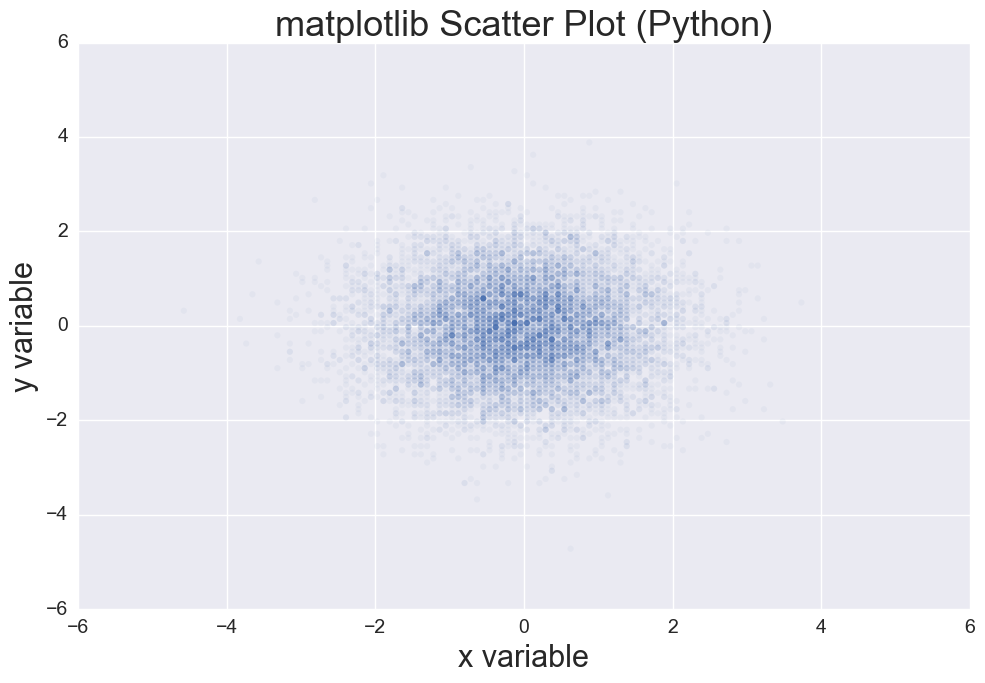

In [20]:
# Manually specify color with opacity proportional to frequency
col = np.zeros((py_scat_df.shape[0], 4))
# Set to blue
col[:, :3] = (0.29, 0.44, 0.69)
# Add transparency
col[:, 3] = py_scat_df.freq/py_scat_df.freq.max()

plt.scatter(py_scat_df.scat_bin_x, py_scat_df.scat_bin_y, c=col, lw=0)
plt.title('matplotlib Scatter Plot (Python)', size=26)
plt.xlabel('x variable', size=22)
plt.ylabel('y variable', size=22)
plt.xticks(size=14)
plt.yticks(size=14)
plt.tight_layout()

plt.savefig('python_scatter_plot.png')

## Generate the ROC Curve

### Local Version

0.895959280823


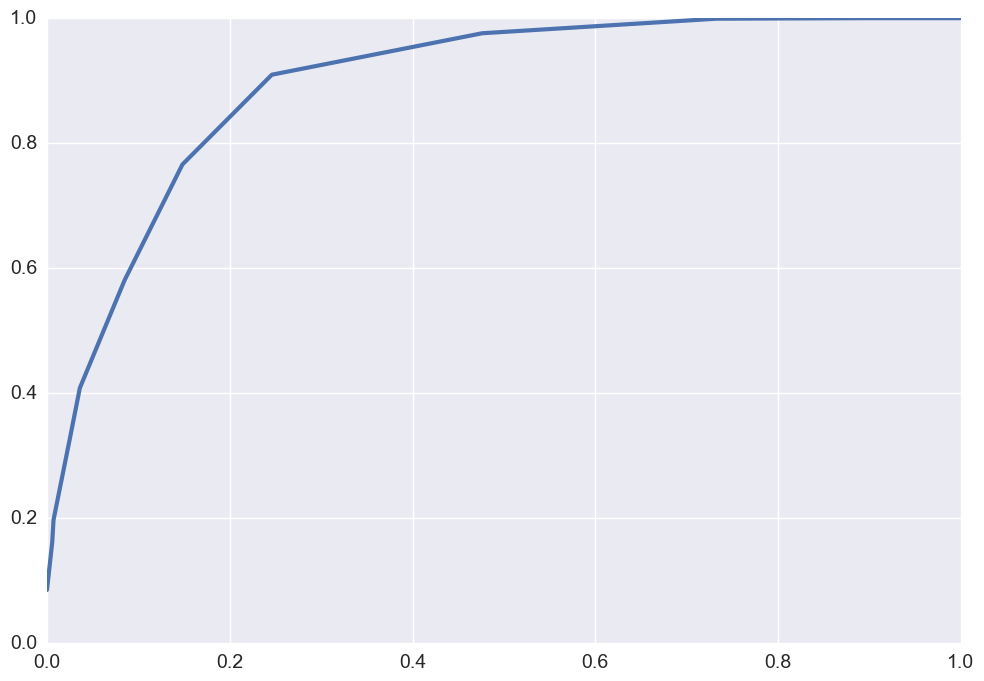

In [21]:
x, y, _ = roc_curve(abalone_df.y, abalone_df['score'])

print roc_auc_score(abalone_df.y, abalone_df['score'])
plt.plot(x, y)
plt.tight_layout()

### In-Database version

0.895959280823


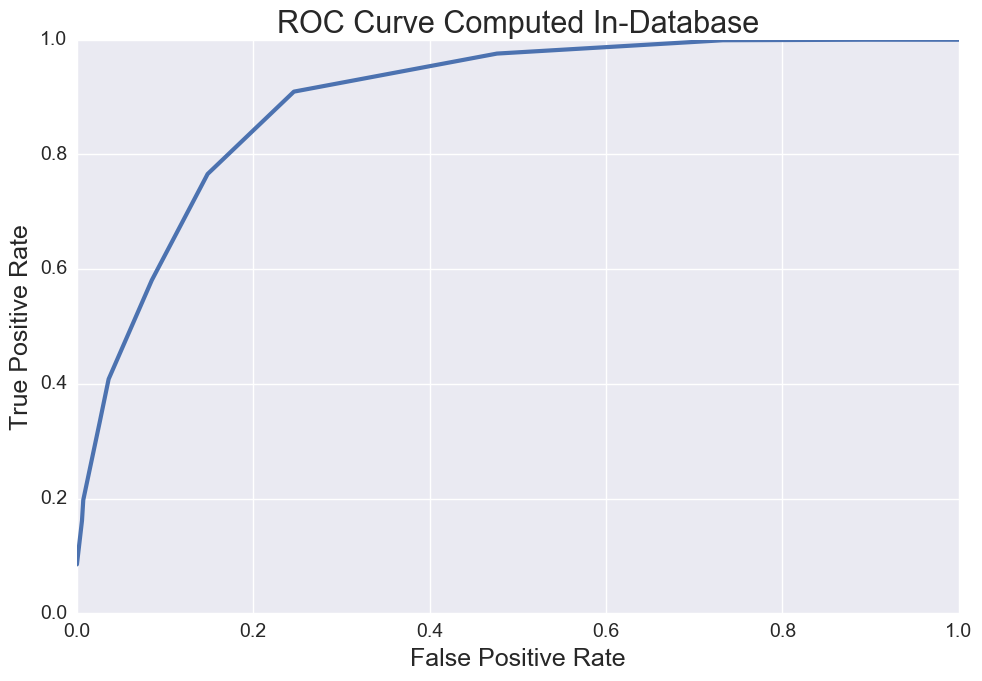

In [22]:
roc_db_df = get_roc_values('model_scores', 'y_true', 'y_score', conn)
plt.plot(roc_db_df.fpr, roc_db_df.tpr)
plt.title('ROC Curve Computed In-Database')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.tight_layout()

plt.savefig('mpp_roc_curve.png')

print get_roc_auc_score(roc_db_df)

In [22]:
%%execsql
DROP TABLE IF EXISTS roc_curve_values;
CREATE TABLE roc_curve_values
     AS WITH row_num_table AS
             (SELECT row_number()
                         OVER (ORDER BY y_score) AS row_num, *
                FROM model_scores
             ),
             pre_roc AS 
             (SELECT *,
                     SUM(y_true)
                         OVER (ORDER BY y_score DESC) AS num_pos,
                     SUM(1 - y_true)
                         OVER (ORDER BY y_score DESC) AS num_neg
                FROM row_num_table
             ),
             class_sizes AS
             (SELECT SUM(y_true) AS tot_pos,
                     SUM(1 - y_true) AS tot_neg
                FROM model_scores
             )
      SELECT DISTINCT
             y_score AS thresholds,
             num_pos/tot_pos::NUMERIC AS tpr,
             num_neg/tot_neg::NUMERIC AS fpr
        FROM pre_roc
             CROSS JOIN class_sizes
--DISTRIBUTED RANDOMLY;

In [23]:
%%readsql -h 10 roc_df
SELECT *
  FROM roc_curve_values
 ORDER BY thresholds;

,thresholds,tpr,fpr
0,0.000000,1.000000,1.000000
1,0.027345,1.000000,0.893525
2,0.292567,0.999138,0.732374
3,0.592979,0.975876,0.476259
4,0.880906,0.909535,0.246043
5,0.937064,0.765939,0.148201
6,0.944239,0.580701,0.084892
7,0.972336,0.408386,0.035971
8,0.975613,0.333716,0.025899
9,0.984387,0.197588,0.007194


0.895959280823
-0.895959280823


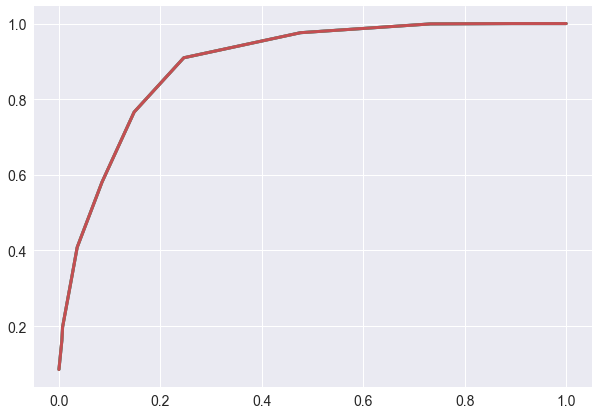

In [24]:
plt.plot(roc_df.fpr, roc_df.tpr)
plt.plot(roc_db_df.fpr, roc_db_df.tpr)
plt.plot(x, y)
print get_roc_auc_score(roc_db_df)
print get_roc_auc_score(roc_df)

In [ ]:
%%readsql
  WITH roc_trapezoids AS
       (SELECT *,
               AVG(tpr)
                   OVER (ORDER BY thresholds DESC
                          ROWS BETWEEN 1 PRECEDING
                           AND CURRENT ROW
                        ) AS avg_height,
               fpr - LAG(fpr, 1)
                   OVER (ORDER BY thresholds DESC)
                   AS width
          FROM roc_curve_values
         ORDER BY thresholds DESC
       )
SELECT SUM(avg_height * width) AS auc_score
  FROM roc_trapezoids

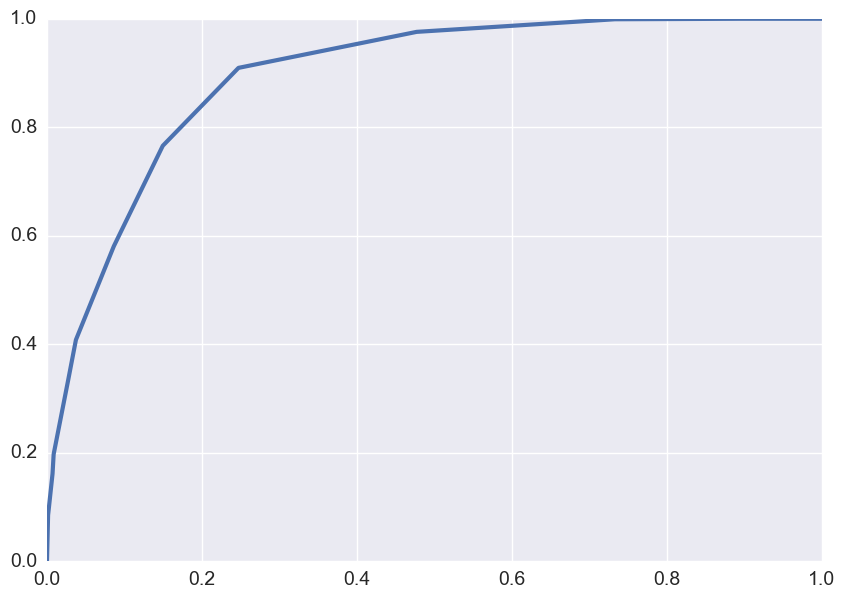

In [46]:
tpr, fpr, _ = roc_curve(abalone_df.y, abalone_df.score)
plt.plot(tpr, fpr)